In [1]:
import networkx as nx
import numpy as np
import z3
import copy
import galois as ga 
# import gf2elim
from graphix.gflow import solvebool

In [2]:
import graphix 
import numpy as np
from graphix import Circuit
import networkx as nx
import matplotlib.pyplot as plt
from graphix.gflow import flow , gflow
from graphix.pattern import *
from graphix.visualization import *


import sympy as sp 


In [3]:
## helper 


def process_layer_data(graph: nx.Graph, layer_map: dict):

    node_attributes = {}; max_l = max(set(layer_map.values()))
    layer_data = {n: set() for n in range(max_l +1 )}

    for v in graph.nodes():
        # print(v); print(layer_data[v])
        node_attributes[v] = {"layer" : layer_map[v]}
        layer_data[layer_map[v]].add(v)

    return {'attribute_data' : node_attributes, 'nodes_in_layers': layer_data, 'num_layers' : max_l  }


def get_nx_graph(pattern: graphix.Pattern):
    nodes, edges = pattern.get_graph()
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)

    return g

def get_pos(pattern: graphix.Pattern, f:dict):

    num_output_nodes = len(pattern.output_nodes)
    flow = [[i] for i in range(num_output_nodes)]
    for i in range(num_output_nodes):
        contd = True
        val = i
        while contd:
            try:
                val = f[val]
                flow[i].append(val)
            except KeyError:
                contd = False
    longest = np.max([len(flow[i]) for i in range(num_output_nodes)])

    pos = dict()
    for i in range(num_output_nodes):
        length = len(flow[i])
        fac = longest / (length - 1)
        for j in range(len(flow[i])):
            pos[flow[i][j]] = (fac * j, -i)
    
    return pos, longest

# determine wheher or not a node will be measured in Pauli basis
def get_clr_list(pattern):
    nodes, edges = pattern.get_graph()
    meas_list = pattern.get_measurement_commands()
    g = get_nx_graph(pattern)
    clr_list = []
    for i in g.nodes:
        for cmd in meas_list:
            if cmd[1] == i:
                if cmd[3] in [-1, -0.5, 0, 0.5, 1]:
                    clr_list.append([0.5, 0.5, 0.5])
                else:
                    clr_list.append([1, 1, 1])
        if i in pattern.output_nodes:
            clr_list.append([0.8, 0.8, 0.8])
    return clr_list

def pretty_plot_pattern(pattern: graphix.Pattern, input_nodes : set):

    clr_list = get_clr_list(pattern)
    g = get_nx_graph(pattern)
    f, l_k = flow(g, input_nodes, set(pattern.output_nodes))
    
    assert isinstance(f, dict)
    pos, length = get_pos(pattern, f) ; layer_data = process_layer_data(g, l_k)
    
    nx.set_node_attributes(g, layer_data['attribute_data'])

    graph_params = {"with_labels": True, "node_size": 600, "node_color": 'w', "edgecolors": "k"}
    pos = nx.multipartite_layout(g, subset_key= 'layer', align='vertical', scale= 100)

    plt.figure(figsize=(25,16))

    for layer in range(layer_data['num_layers']):   
        vertx_1 = next(iter(layer_data['nodes_in_layers'][layer])); xcoord_1 = pos[vertx_1][0]
        vertx_2 = next(iter(layer_data['nodes_in_layers'][layer + 1])); xcoord_2 = pos[vertx_2][0]
        xcoord = np.mean([xcoord_1, xcoord_2])
        plt.axvline(xcoord)
        plt.text(x= xcoord + 1.5, y= -18, s= 'l= ' + str(layer) )

    edge_color= []
    for u,v in g.edges():
        if( u not in pattern.output_nodes and v not in pattern.output_nodes ) :
            # print (u,v, u==f[v] or v== f[u])
            if u==f[v] or v== f[u] :
                edge_color.append('r')
            else :
                edge_color.append('g')


    nx.draw_networkx(g, pos= pos, **graph_params, edge_color = edge_color)

    
    

            

In [4]:
def build_random_circuit(n: int, params: list = None, random: bool = True ):

    # assert len(params) == n * layers ## checks

    c = Circuit(n)
    p_stop = 1.0 
    
    for _ in range(10):
        while np.random.random() <= p_stop : 
            # print(p_stop)
            for i in range(np.random.randint(1,n)): ## circular entangelemnt 
                if random:
                    js = np.random.choice(range(n), size= np.random.randint(int(n/2)))
                    for j in js : 
                        if j != i:
                            c.cnot(i, j)    

                # else:
                #     c.cnot(i %n,(i+1)%n)

            for i in range(np.random.randint(1,n)): ## paramterised rx rotations 
                if random :
                    c.rx(i, np.random.random() * 2 * np.pi) 

                    # else:
                        # c.rx(i, params[ n*l + i]) 

            p_stop = p_stop - 0.01

        return c

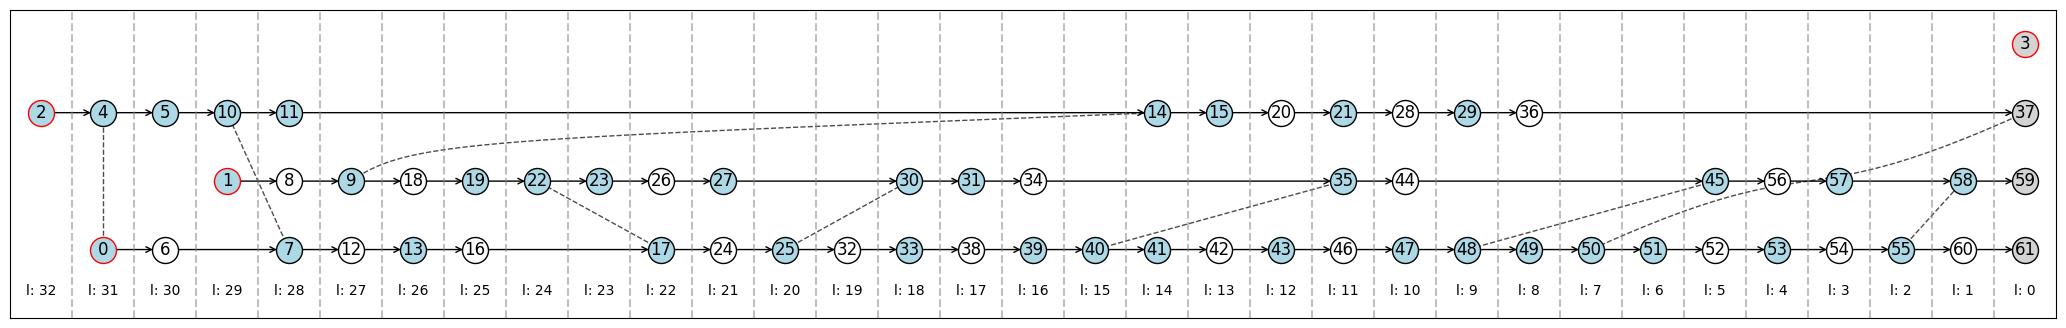

In [5]:
c = build_random_circuit(4);

# c.instruction
ptrn = c.standardize_and_transpile()
grph = get_nx_graph(ptrn)

# nx.draw_networkx(grph,)
ptrn.view_graph()

/tmp/ipykernel_5639/2201588582.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  fac = longest / (length - 1)
/tmp/ipykernel_5639/2201588582.py:45: RuntimeWarning: invalid value encountered in scalar multiply
  pos[flow[i][j]] = (fac * j, -i)


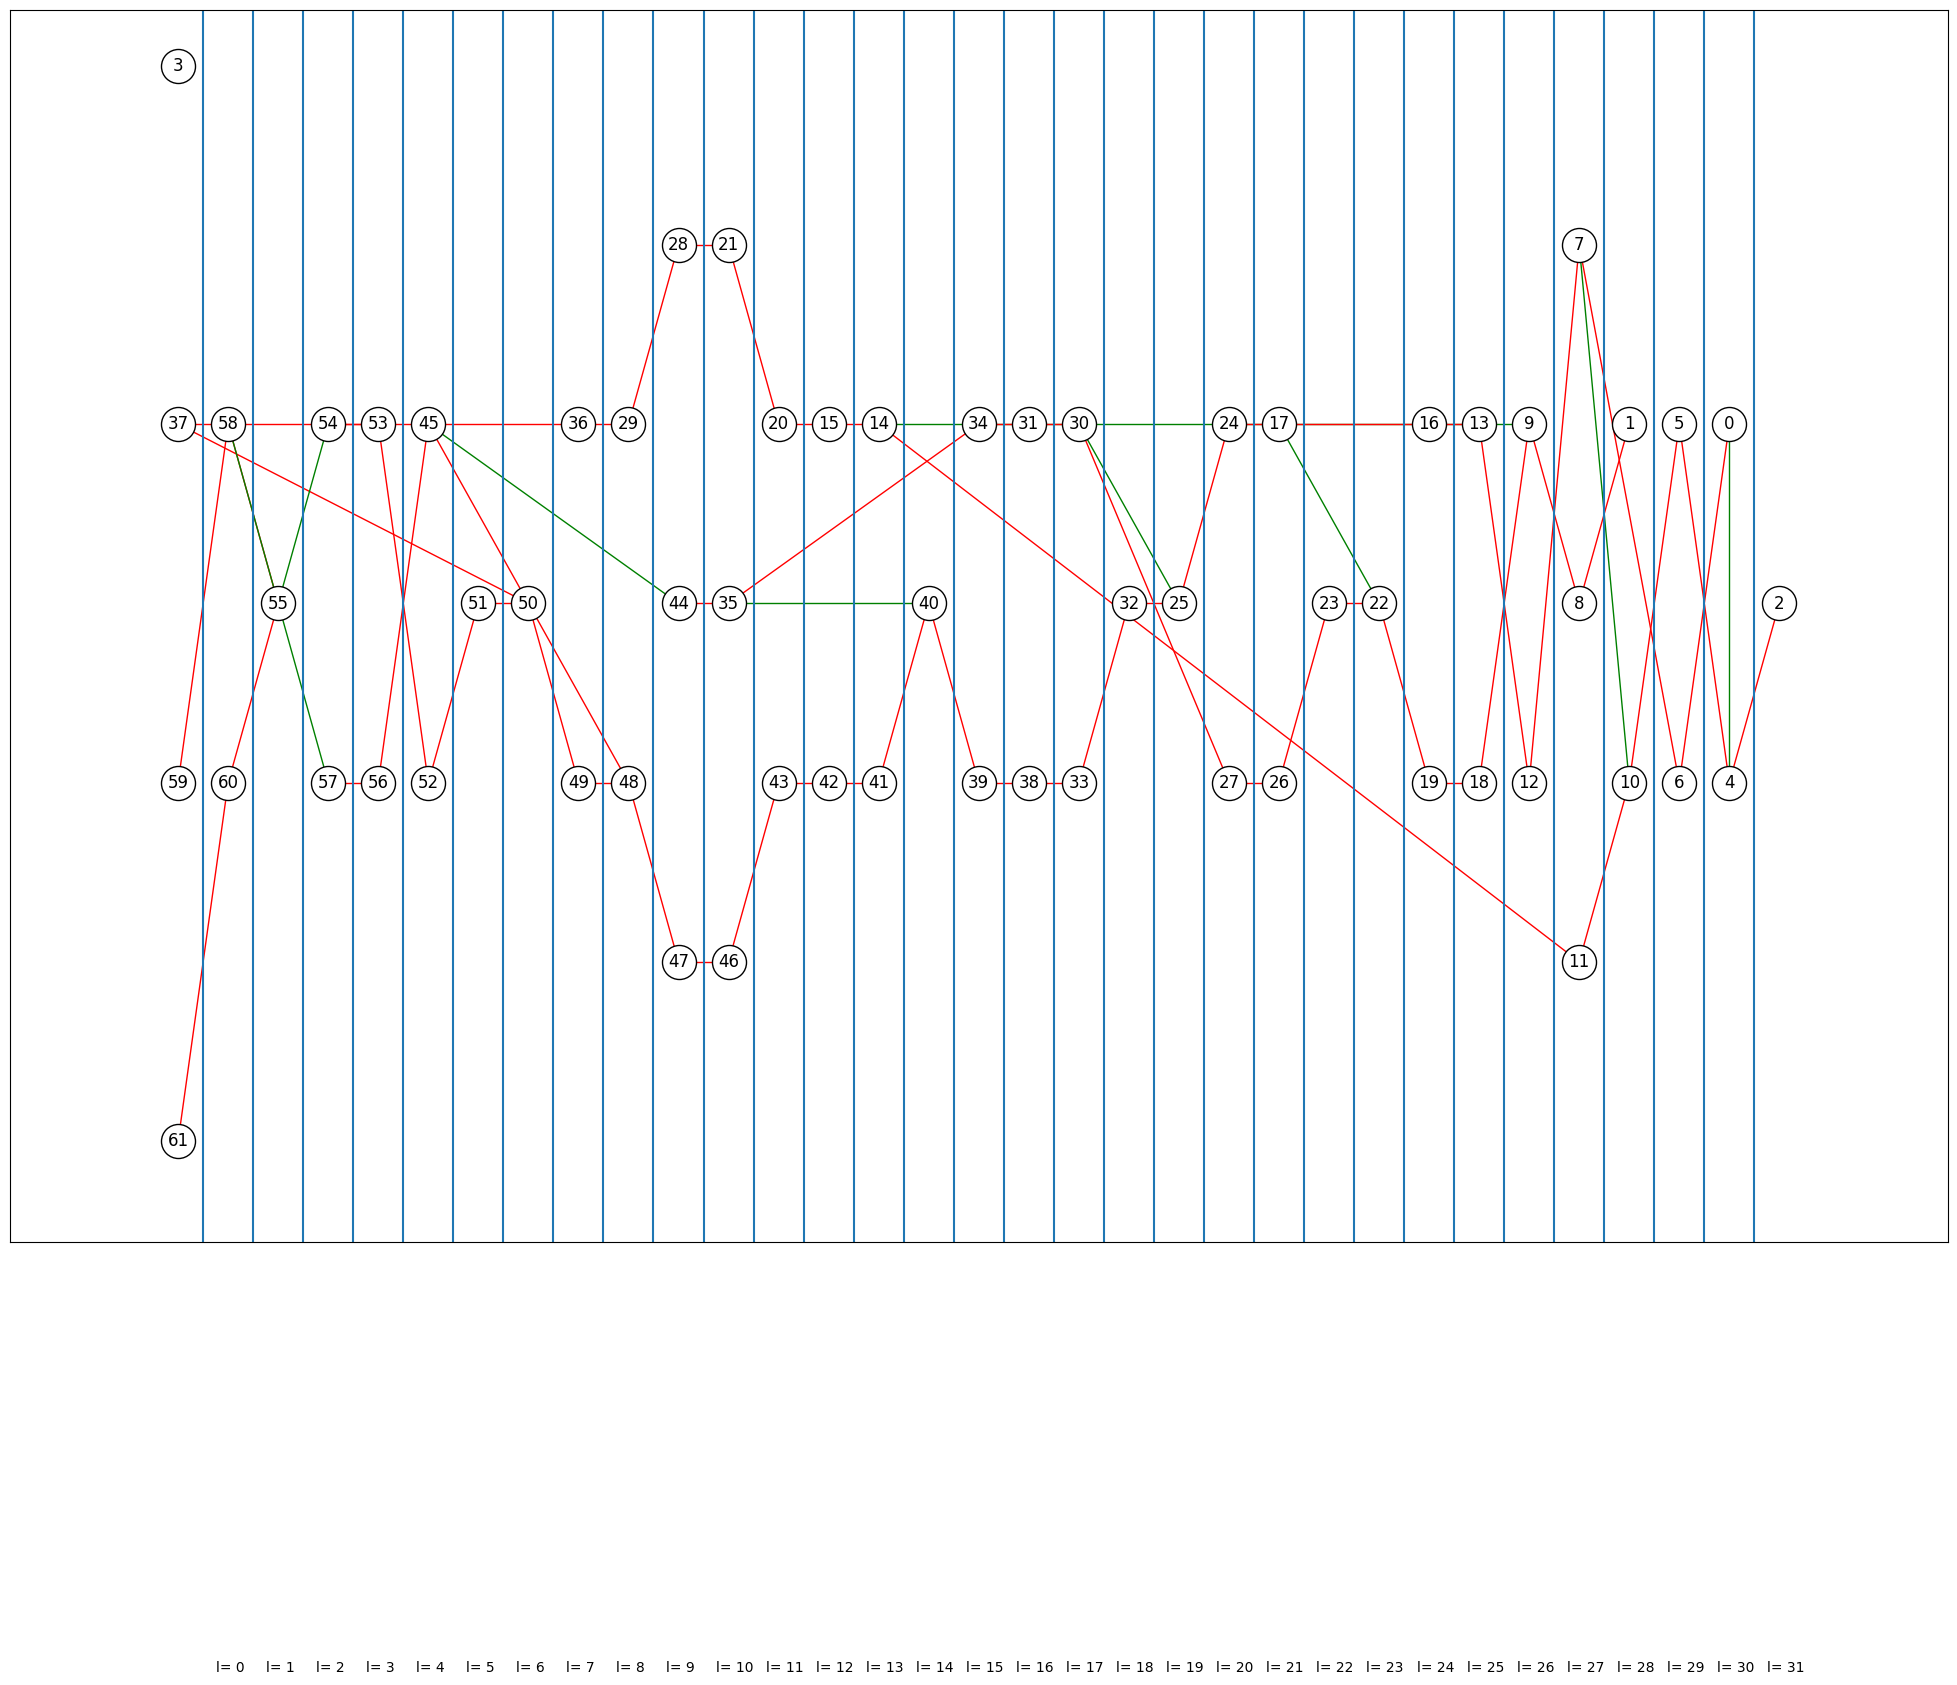

In [10]:
pretty_plot_pattern(ptrn, {0,1,2,3})

In [6]:
adj = nx.to_numpy_array(grph)
adj_b = []
for i in range(len(adj)):
    s = ''.join([str(int(elem)) for elem in adj[i]])
    adj_b.append(s[::-1])
adj_b.sort()
adj_b

['00000000000000000000000000000000000000000000000000000000000000',
 '00000000000000000000000000000000000000000000000000000000010000',
 '00000000000000000000000000000000000000000000000000000000100101',
 '00000000000000000000000000000000000000000000000000000001010000',
 '00000000000000000000000000000000000000000000000000000010000001',
 '00000000000000000000000000000000000000000000000000000100000000',
 '00000000000000000000000000000000000000000000000000001000000010',
 '00000000000000000000000000000000000000000000000000010000010000',
 '00000000000000000000000000000000000000000000000000100010100000',
 '00000000000000000000000000000000000000000000000001010001000000',
 '00000000000000000000000000000000000000000000000010000010000000',
 '00000000000000000000000000000000000000000000000100010000000000',
 '00000000000000000000000000000000000000000000001000101000000000',
 '00000000000000000000000000000000000000000000010001000000000000',
 '000000000000000000000000000000000000000000001000100000000000

In [7]:
int(adj_b[0],2)

0

In [8]:
a = '112'
a[::-1]

'211'